# Predict Prices on laptops using their features
- Price is a target of prediction
- Brand, Processor Speed, RAM Size, Storage Capacity, Screen Size and Weight - the features

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# Reading Raw data from .csv file

In [2]:
raw_data = pd.read_csv('./data/Laptop_price.csv')
raw_data.head(10)

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718
5,HP,1.881348,16,256,11.943958,4.840268,9543.719980
6,Lenovo,2.940721,32,256,11.713246,4.344846,10390.137319
7,Lenovo,3.016788,4,256,15.588315,2.941120,9214.484506
8,Lenovo,2.560327,4,512,15.026332,2.743620,16372.175284
9,Acer,3.341111,32,512,13.611945,4.093149,18501.832733


# Exploring column types and probbable missing values

In [103]:
raw_data.dtypes

Brand                object
Processor_Speed     float64
RAM_Size              int64
Storage_Capacity      int64
Screen_Size         float64
Weight              float64
Price               float64
dtype: object

In [104]:
raw_data[raw_data.isna().any(axis=1)] # no `None`s or `numpy.NaN`s

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price


In [105]:
features, target = raw_data.loc[:, raw_data.columns != 'Price'], raw_data['Price']
features: pd.DataFrame
features

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight
0,Asus,3.830296,16,512,11.185147,2.641094
1,Acer,2.912833,4,1000,11.311372,3.260012
2,Lenovo,3.241627,4,256,11.853023,2.029061
3,Acer,3.806248,16,512,12.280360,4.573865
4,Acer,3.268097,32,1000,14.990877,4.193472
...,...,...,...,...,...,...
995,HP,3.343584,4,1000,12.587095,3.162399
996,Dell,2.780555,8,256,12.679356,3.750265
997,Dell,3.200569,4,512,12.666315,3.392612
998,Asus,1.604182,8,256,11.215581,3.857613


## Exploring outliers

In [106]:
print(f"#{'='*23}#")
brand = features['Brand']
counts = brand.value_counts()
print(counts) # no trailing whitespaces, no outliers
print(f"#{'='*23}#")
print(f"Value counts avg: {counts.mean():.2f}") # evenly destributed
print(f"#{'='*23}#")

#=======================#
Brand
Dell      210
Asus      206
Acer      204
Lenovo    190
HP        190
Name: count, dtype: int64
#=======================#
Value counts avg: 200.00
#=======================#


<Axes: ylabel='Frequency'>

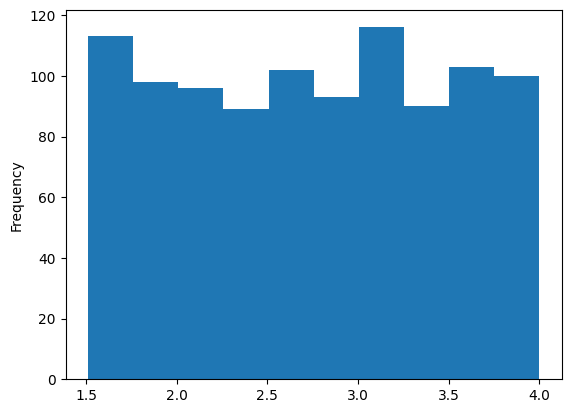

In [141]:
raw_data['Processor_Speed'].plot.hist() # almost Uniform

<Axes: ylabel='Frequency'>

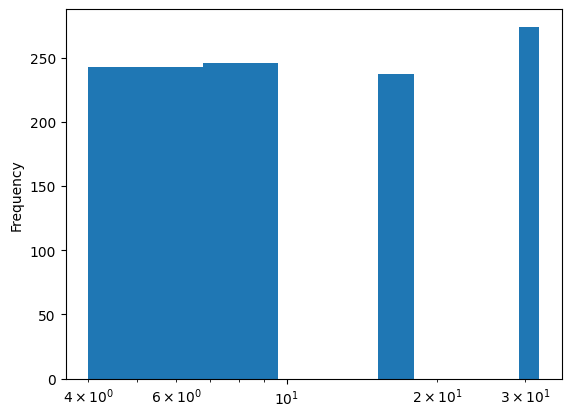

In [152]:
raw_data['RAM_Size'].plot.hist(logx=True) # almost Uniform on selection between 4, 8, 16 and 32

<Axes: ylabel='Frequency'>

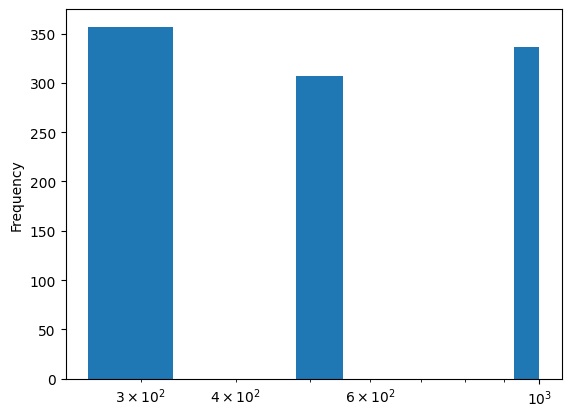

In [147]:
raw_data['Storage_Capacity'].plot.hist(logx=True) # almost Uniform on selection between 256, 512 and 1024

<Axes: ylabel='Frequency'>

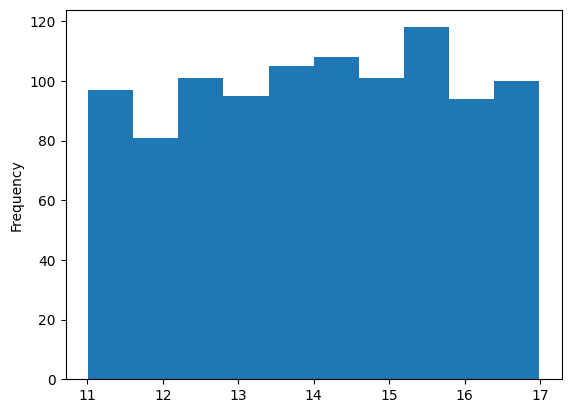

In [144]:
raw_data['Screen_Size'].plot.hist() # almost Uniform

<Axes: ylabel='Frequency'>

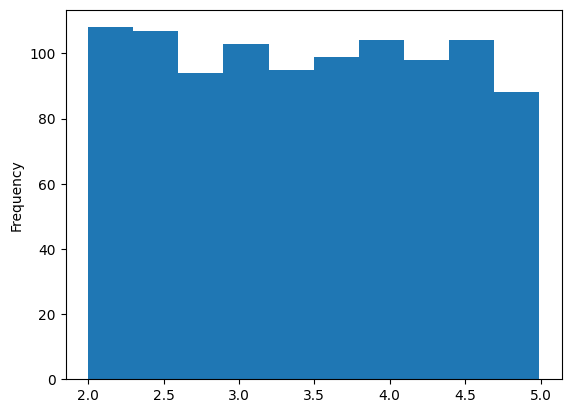

In [145]:
raw_data['Weight'].plot.hist() # almost Uniform

<Axes: ylabel='Frequency'>

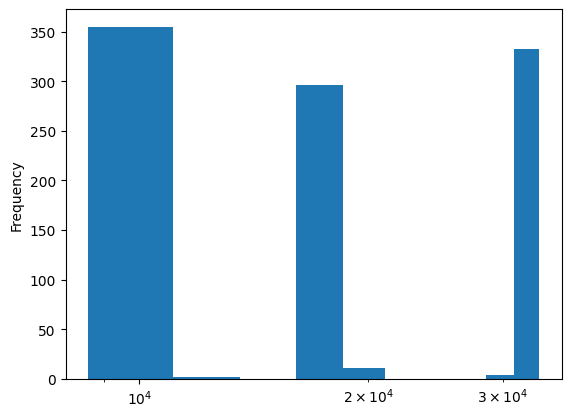

In [157]:
raw_data['Price'].plot.hist(logx=True)

## Firsthand result
- Columns mostly Uniformly distrubited between values
- Price is highly correlated with Storage Capacity (will re-check it with correlation matrix)
- Prices have outliers in each group (near 8k, 16k, 32k)

<Axes: >

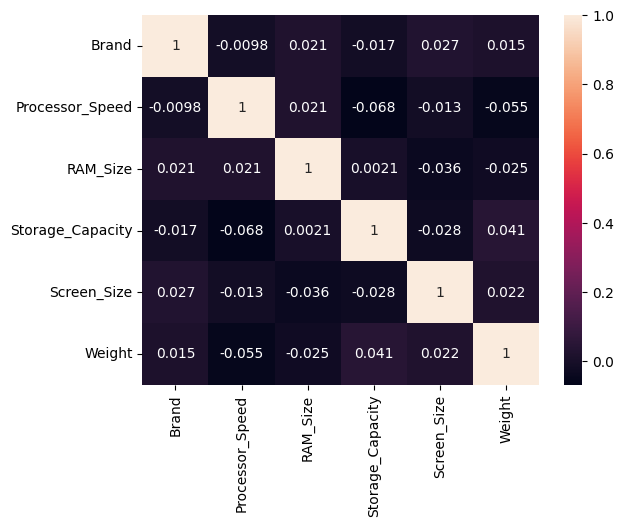

In [112]:
corr_matrix = decimal_features.corr()
sns.heatmap(corr_matrix, annot=True)

In [113]:
mask = np.eye(corr_matrix.shape[0], dtype=bool) # mask to filter diagonal with same labels
hi_corr_labels = (corr_matrix.mask(mask).abs() >= 0.5).any() # labels that have high corelation with anything
hi_corr_labels # no strongly related features were found

Brand               False
Processor_Speed     False
RAM_Size            False
Storage_Capacity    False
Screen_Size         False
Weight              False
dtype: bool

## Doing same for all columns including target

<Axes: >

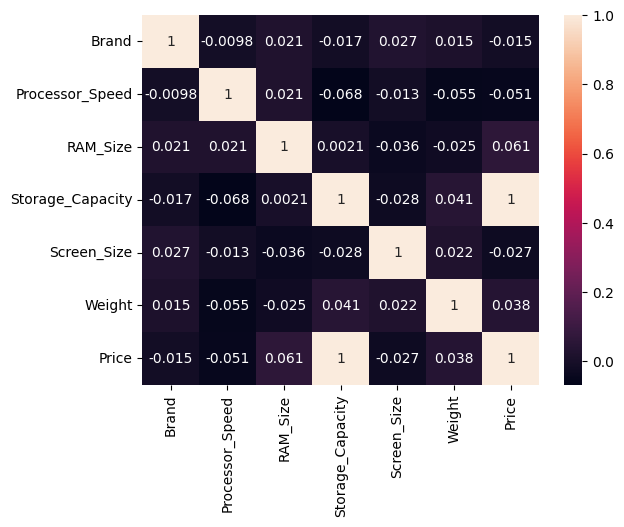

In [120]:
corr_matrix_with_target = raw_data.replace({'Brand': brand_mapping}).corr()
sns.heatmap(corr_matrix_with_target, annot=True)

Brand               False
Processor_Speed     False
RAM_Size            False
Storage_Capacity     True
Screen_Size         False
Weight              False
Price                True
dtype: bool


<Axes: >

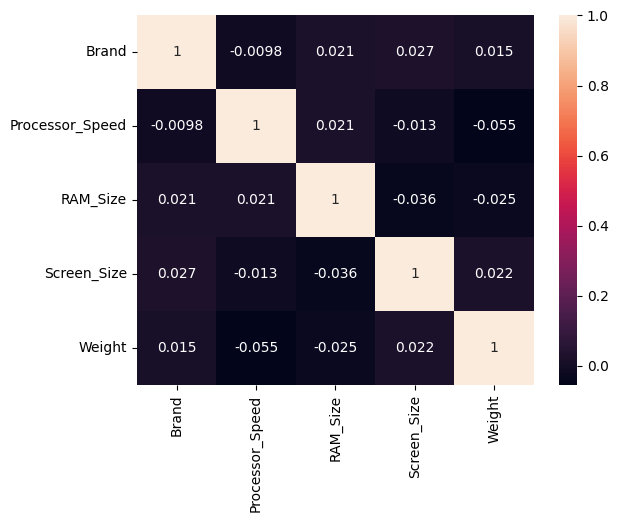

In [124]:
mask = np.eye(corr_matrix_with_target.shape[0], dtype=bool)
hi_corr_labels = (corr_matrix_with_target.mask(mask).abs() >= 0.5).any()
print(hi_corr_labels) # 'Price' and 'Storage_Capacity' have strong relation

# NOTE: Maybe should remove only one strongly related feature
#       instead of all of them.
corr_filtered = corr_matrix_with_target.loc[~hi_corr_labels, ~hi_corr_labels] # remove higly correlated columns
sns.heatmap(corr_filtered, annot=True)

## Secondhand results:
- Data has no missing values
- According to correlation matrix, there are only 1 pair of strongly related features - (Storage Capacity, Price)

## Find important features with Gain Ratio

In [167]:
# Splitting data
features: pd.DataFrame = raw_data.loc[:, (raw_data.columns != 'Price')
                            & (raw_data.columns != 'Storage_Capacity')] \
                        .replace({'Brand': brand_mapping})

features.head()

,Brand,Processor_Speed,RAM_Size,Screen_Size,Weight
0,0.206,3.830296,16,11.185147,2.641094
1,0.204,2.912833,4,11.311372,3.260012
2,0.19,3.241627,4,11.853023,2.029061
3,0.204,3.806248,16,12.280360,4.573865
4,0.204,3.268097,32,14.990877,4.193472


In [170]:
clf = DecisionTreeRegressor(random_state=0)
clf.fit(features, target)

DecisionTreeRegressor(random_state=0)

In [171]:
gain_ratios = {}
# Print the gain ratio for each feature
for gain, split, feature in zip(clf.feature_importances_, clf.tree_.impurity, features.columns):
    gain_ratio = gain / split
    print(f'Gain ratio for {feature}: {gain_ratio:.3f}')

    gain_ratios[feature] = gain_ratio

# Find the feature with the highest gain ratio
best_feature = max(gain_ratios, key=gain_ratios.get)

print(f'Best feature: {best_feature}')

Gain ratio for Brand: 0.000
Gain ratio for Processor_Speed: 0.000
Gain ratio for RAM_Size: 0.000
Gain ratio for Screen_Size: 0.000
Gain ratio for Weight: 0.000
Best feature: Screen_Size
